In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
cuaca = pd.read_excel("Semarang.xlsx", parse_dates=['Tanggal'], index_col='Tanggal')
cuaca

NameError: name 'pd' is not defined

In [ ]:
cuaca.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2525 entries, 2017-02-01 to 2023-12-31
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Tn       2525 non-null   float64
 1   Tx       2525 non-null   float64
 2   Tavg     2525 non-null   float64
 3   RH_avg   2525 non-null   float64
 4   RR       2525 non-null   float64
 5   ss       2525 non-null   float64
 6   ff_x     2525 non-null   float64
 7   ddd_x    2525 non-null   float64
 8   ff_avg   2525 non-null   float64
 9   ddd_car  2387 non-null   object 
dtypes: float64(9), object(1)
memory usage: 217.0+ KB


In [ ]:
cuaca.isna().sum()

,0
Tn,0
Tx,0
Tavg,0
RH_avg,0
RR,0
ss,0
ff_x,0
ddd_x,0
ff_avg,0
ddd_car,138


In [ ]:
cuaca['ddd_car'].fillna(cuaca['ddd_car'].mode()[0], inplace=True)
cuaca.isna().sum()

<ipython-input-5-a20f95dd1736>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cuaca['ddd_car'].fillna(cuaca['ddd_car'].mode()[0], inplace=True)


,0
Tn,0
Tx,0
Tavg,0
RH_avg,0
RR,0
ss,0
ff_x,0
ddd_x,0
ff_avg,0
ddd_car,0


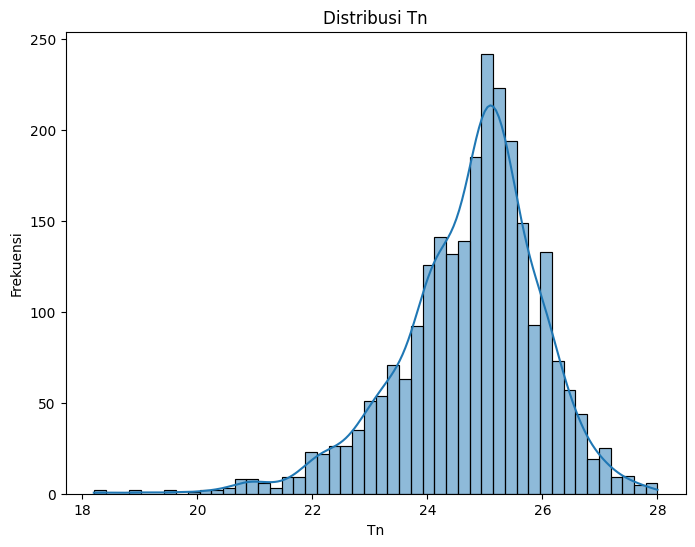

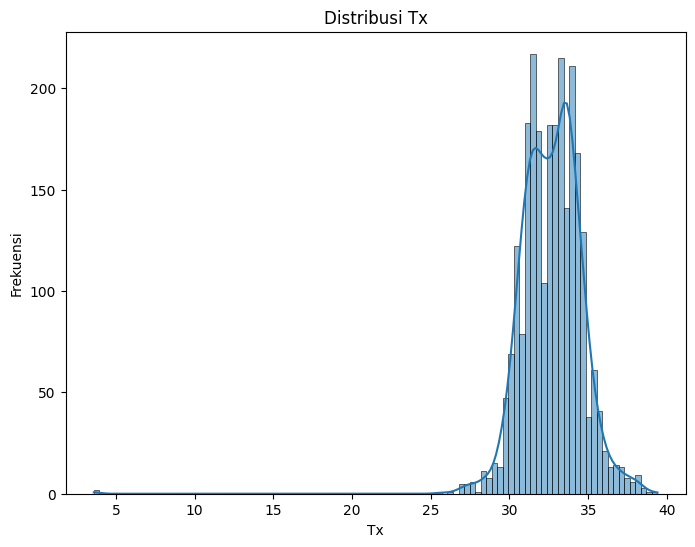

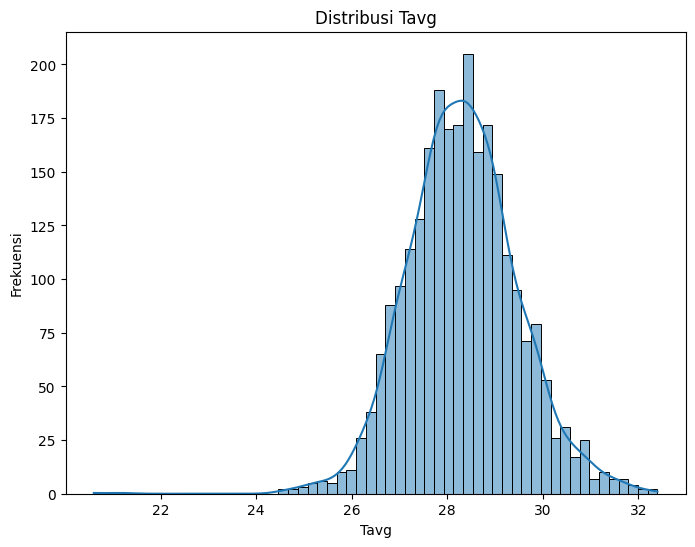

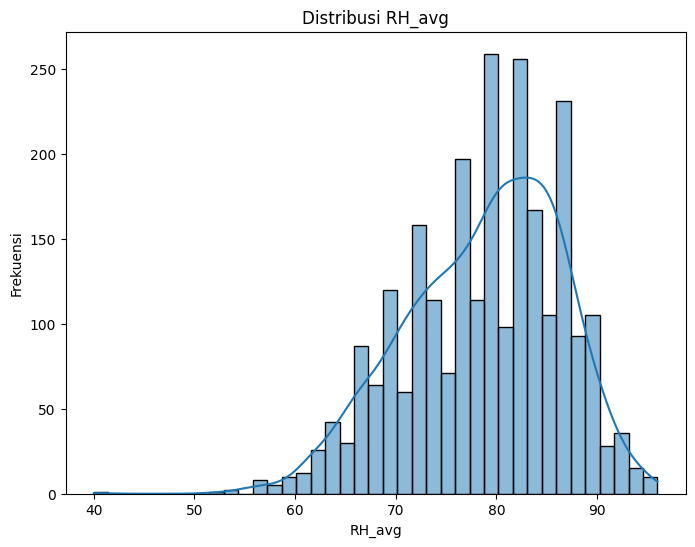

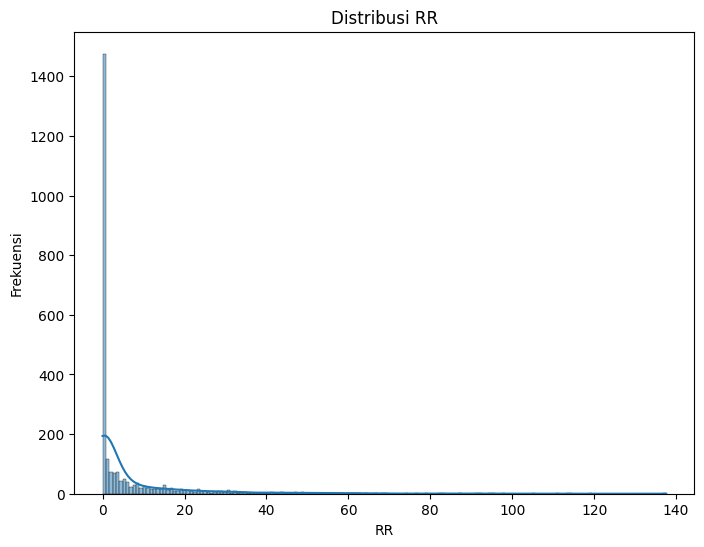

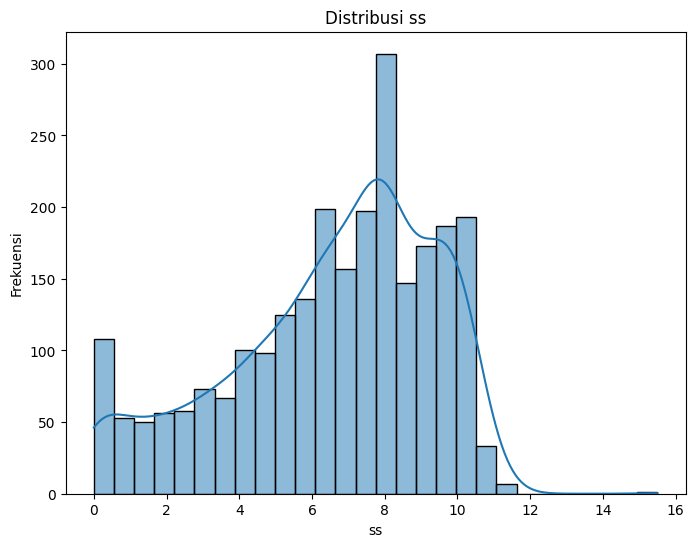

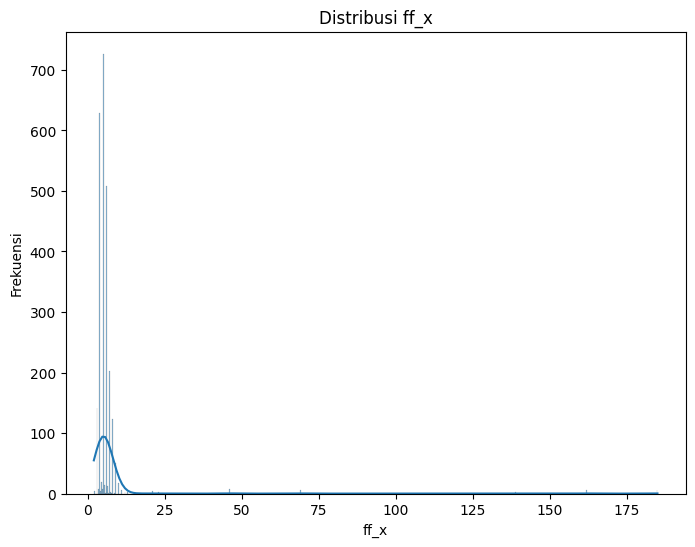

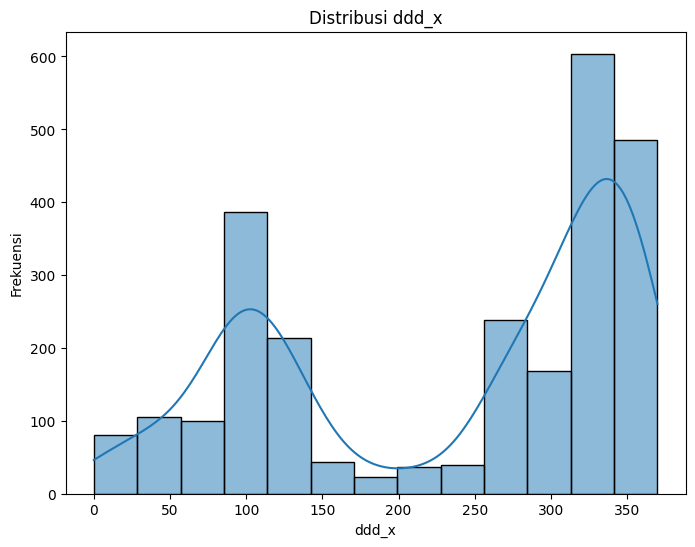

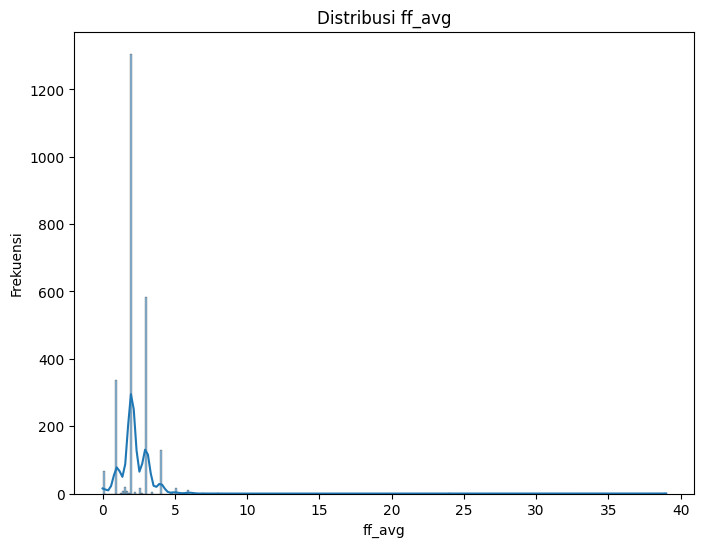

In [ ]:
# Pilih variabel numerik yang ingin Anda visualisasikan
numerical_features = ['Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ddd_x', 'ff_avg']

# Buat histogram menggunakan Seaborn
for feature in numerical_features:
    plt.figure(figsize=(8, 6))  # Atur ukuran gambar
    sns.histplot(cuaca[feature], kde=True)  # kde=True menambahkan kurva kepadatan
    plt.title(f'Distribusi {feature}')  # Atur judul
    plt.xlabel(feature)  # Atur label sumbu x
    plt.ylabel('Frekuensi')  # Atur label sumbu y
    plt.show()  # Tampilkan histogram

In [ ]:
cuaca.drop('ddd_car', axis=1, inplace=True)

NameError: name 'cuaca' is not defined

In [ ]:
# Feature Engineering: Menambahkan fitur waktu
cuaca['Month'] = cuaca.index.month
cuaca['DayOfYear'] = cuaca.index.dayofyear
cuaca['DayOfWeek'] = cuaca.index.dayofweek

# Feature Engineering: Menambahkan fitur statistik berbasis waktu
cuaca['Tavg_7d'] = cuaca['Tavg'].rolling(window=7, min_periods=1).mean()
cuaca['RH_avg_7d'] = cuaca['RH_avg'].rolling(window=7, min_periods=1).mean()

# Feature Engineering: Interaksi variabel cuaca
cuaca['RH_RR_interaction'] = cuaca['RH_avg'] * cuaca['RR']

In [ ]:
def create_lags(cuaca, lags=30):
    for i in range(1, lags + 1):
        cuaca[f'lag_{i}'] = cuaca['Tavg'].shift(i)
    return cuaca

cuaca = create_lags(cuaca, lags=30)

In [ ]:
cuaca.dropna(inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cuaca_scaled = pd.DataFrame(scaler.fit_transform(cuaca), columns=cuaca.columns, index=cuaca.index)

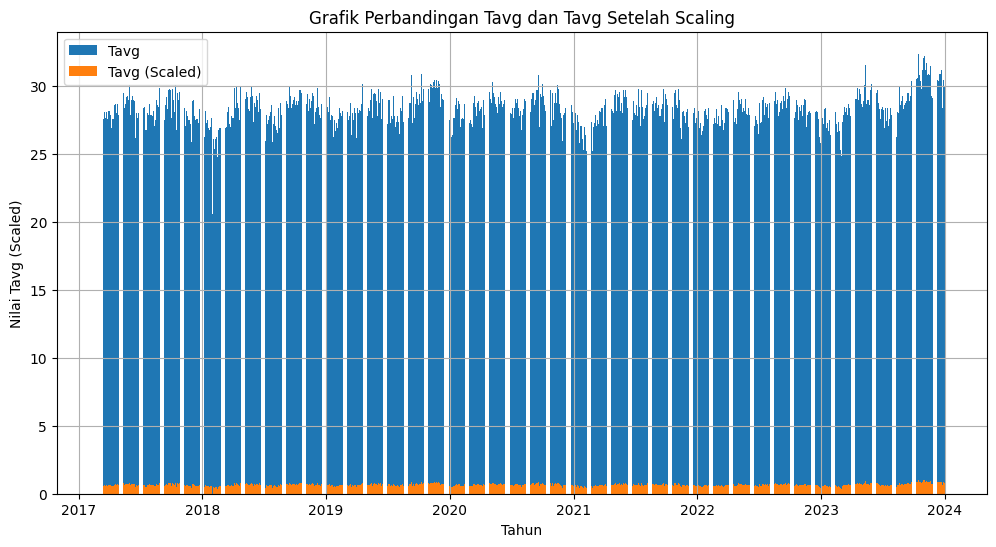

In [ ]:
plt.figure(figsize=(12, 6))  # Atur ukuran gambar
plt.bar(cuaca_scaled.index, cuaca['Tavg'], label='Tavg')
plt.bar(cuaca_scaled.index, cuaca_scaled['Tavg'], label='Tavg (Scaled)')
plt.title('Grafik Perbandingan Tavg dan Tavg Setelah Scaling')
plt.xlabel('Tahun')
plt.ylabel('Nilai Tavg (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
features = ['Tn', 'Tx', 'RH_avg', 'RR', 'ss', 'ff_x', 'ddd_x', 'ff_avg', 'Month', 'DayOfYear', 'DayOfWeek', 'Tavg_7d', 'RH_avg_7d', 'RH_RR_interaction']
X = cuaca_scaled[features]
y = cuaca_scaled['Tavg']

In [ ]:
# Pisahkan cuaca latih dan uji secara time series
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = reg.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(np.column_stack([y_pred] + [np.zeros(y_test.shape) for _ in range(len(cuaca.columns)-1)]))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] + [np.zeros(y_test.shape) for _ in range(len(cuaca.columns)-1)]))[:, 0]

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Evaluasi model
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    accuracy = 100 - (mean_absolute_error(y_true, y_pred) / np.mean(y_true) * 100)
    print(f"\nEvaluasi Model {model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")
    return mae, mse, rmse, r2, accuracy

evaluate_model(y_test_rescaled, y_pred_rescaled, "Linear Regression")


Evaluasi Model Linear Regression:
MAE: 0.2775
MSE: 0.1238
RMSE: 0.3519
R2 Score: 0.9046
Accuracy: 98.89%


(0.27747363853839174,
 0.12380218108537243,
 np.float64(0.35185534113520633),
 0.9046077418648621,
 np.float64(98.88660760646384))

In [ ]:
results = pd.DataFrame({'Actual': y_test_rescaled, 'Predicted': y_pred_rescaled})

# Mengurutkan DataFrame berdasarkan index
results_sorted = results.sort_index()

# Menampilkan 5 baris pertama dan 5 baris terakhir
print(pd.concat([results_sorted.head(), results_sorted.tail()]))

        Actual  Predicted
0    24.761017  25.150641
1    24.844068  25.174863
2    24.927119  24.998675
3    25.010169  24.788776
4    25.840678  25.567466
494  26.754237  26.172707
495  26.422034  26.364301
496  27.252542  26.497135
497  26.006780  26.431560
498  26.006780  25.528091


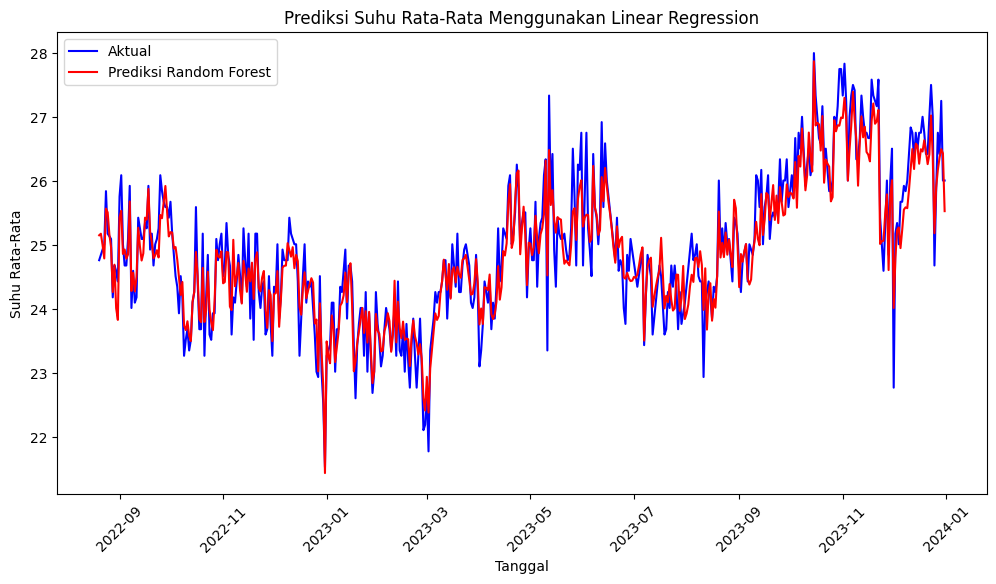

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(cuaca.index[train_size:], y_test_rescaled, label='Aktual', linestyle='-', color='blue')
plt.plot(cuaca.index[train_size:], y_pred_rescaled, label='Prediksi Random Forest', linestyle='-', color='red')
plt.xlabel("Tanggal")
plt.ylabel("Suhu Rata-Rata")
plt.title("Prediksi Suhu Rata-Rata Menggunakan Linear Regression")
plt.legend()
plt.xticks(rotation=45)
plt.show()